In [1]:
import os
from osgeo import gdal
from gdalconst import *

import sys
import numpy as np
from matplotlib import pyplot as plt

gdal.UseExceptions()

print(gdal.__version__)

2.3.3


# Exercício - criar uma função salvar_banda para salvar um raster de uma banda, tendo como parâmetros uma matriz NumPy com os pixels, o nome do arquivo GeoTIFF, e um dataset de referência (para copiar os metadados)

In [3]:
def salvar_banda(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    # obter metadados
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1
    # definir driver
    driver = gdal.GetDriverByName('GTiff')
    # copiar tipo de dados da banda já existente
    data_type = dataset_de_referencia.GetRasterBand(1).DataType
    # criar novo dataset
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type)
    # copiar informações espaciais da banda já existente
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform())
    # copiar informações de projeção
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef())
    # escrever dados da matriz NumPy na banda
    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels)
    # salvar valores
    dataset_output.FlushCache()
    # fechar dataset
    dataset_output = None

# Exercício - Dadas 3 imagens (raster_alvo 1 e 2, e raster_entrada), encontrar a localização da imagem raster_alvo dentro da imagem raster_entrada e plotar o resultado (raster_entrada com um x sobreposto na localização)

In [7]:
f_jpg = os.path.join(os.getcwd(), 'jpeg')
f_jpg

'D:\\prog\\GitHub\\portfolio-python\\advanced-exercises\\jpeg'

In [8]:
os.listdir(f_jpg)

['american-anticipation-audience-163368.jpg', 'target_1.jpg', 'target_2.jpg']

In [9]:
arquivo_ref = os.path.join(f_jpg, 'american-anticipation-audience-163368.jpg')
alvo_1 = os.path.join(f_jpg, 'target_1.jpg')
alvo_2 = os.path.join(f_jpg, 'target_2.jpg')

try:
    dataset_ref = gdal.Open(arquivo_ref, GA_ReadOnly)
    dataset_alvo_1 = gdal.Open(alvo_1, GA_ReadOnly)
    dataset_alvo_2 = gdal.Open(alvo_2, GA_ReadOnly)
except:
    print('Erro na abertura de algum arquivo!')

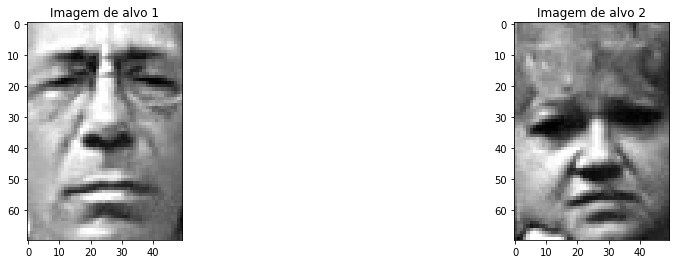

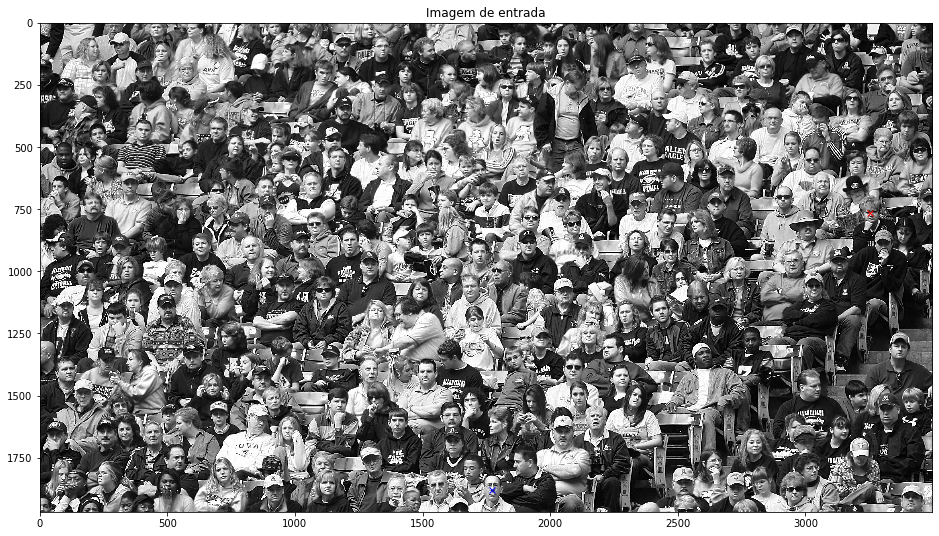

In [10]:
if (dataset_ref.GetProjectionRef() != dataset_alvo_1.GetProjectionRef()) and (dataset_ref.GetProjectionRef() != dataset_alvo_2.GetProjectionRef()):
    print("Sistemas de referência diferentes")
elif (dataset_ref.GetGeoTransform() != dataset_alvo_1.GetGeoTransform()) and (dataset_ref.GetGeoTransform() != dataset_alvo_2.GetGeoTransform()):
    print("Metadados espaciais diferentes")
else:
    linhas_ref = dataset_ref.RasterYSize
    colunas_ref = dataset_ref.RasterXSize
    
    # obter metadados da imagem de alvo
    linhas_alvo_1 = dataset_alvo_1.RasterYSize
    colunas_alvo_1 = dataset_alvo_1.RasterXSize
    linhas_alvo_2 = dataset_alvo_2.RasterYSize
    colunas_alvo_2 = dataset_alvo_2.RasterXSize

    # obter as bandas
    banda_ref = dataset_ref.GetRasterBand(1).ReadAsArray()
    banda_alvo_1 = dataset_alvo_1.GetRasterBand(1).ReadAsArray()
    banda_alvo_2 = dataset_alvo_2.GetRasterBand(1).ReadAsArray()

    # encontrar linha/coluna do alvo 1 na imagem de entrada
    linha_1 = 0
    coluna_1 = 0
    # criar variável para armazenar a região de maior semelhança
    maior_semelhanca_1 = 0
    for r in range(linhas_ref - linhas_alvo_1):
      for c in range(colunas_ref - colunas_alvo_1):
        # criar janela com recorte do mesmo tamanho da banda_alvo
        janela_1 = banda_ref[r:r+linhas_alvo_1, c:c+colunas_alvo_1]
        # comparar quantos pixels são iguais entre as duas janelas
        pixels_iguais_1 = (banda_alvo_1 == janela_1)
        somatorio_1 = pixels_iguais_1.sum()
        if (somatorio_1 > maior_semelhanca_1):
          linha_1 = r
          coluna_1 = c
          maior_semelhanca_1 = somatorio_1
        
    # encontrar linha/coluna do alvo 2 na imagem de entrada
    linha_2 = 0
    coluna_2 = 0
    # criar variável para armazenar a região de maior semelhança
    maior_semelhanca_2 = 0
    for r in range(linhas_ref - linhas_alvo_2):
      for c in range(colunas_ref - colunas_alvo_2):
        # criar janela com recorte do mesmo tamanho da banda_alvo
        janela_2 = banda_ref[r:r+linhas_alvo_2, c:c+colunas_alvo_2]
        # comparar quantos pixels são iguais entre as duas janelas
        pixels_iguais_2 = (banda_alvo_2 == janela_2)
        somatorio_2 = pixels_iguais_2.sum()
        if (somatorio_2 > maior_semelhanca_2):
          linha_2 = r
          coluna_2 = c
          maior_semelhanca_2 = somatorio_2

    # apresentar resultado
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Imagem de alvo 1')
    plt.imshow(banda_alvo_1, cmap = 'gray')
    
    plt.subplot(122)
    plt.title('Imagem de alvo 2')
    plt.imshow(banda_alvo_2, cmap = 'gray')

    plt.figure(figsize=(16, 9))
    plt.imshow(banda_ref, cmap = 'gray', aspect='auto')
    plt.title('Imagem de entrada')
    plt.plot(coluna_1 + colunas_alvo_1 / 2,  linha_1 + linhas_alvo_1 / 2, 'bx')
    plt.plot(coluna_2 + colunas_alvo_2 / 2,  linha_2 + linhas_alvo_2 / 2, 'rx')

    plt.show()

    # fechar os arquivos
    dataset_ref = None
    dataset_alvo_1 = None
    dataset_alvo_2 = None

# Exercício - dados dois rasters de 1 banda cada (1 mapa temático, 1 mapa de referência), calcule a taxa de acerto da classificação do mapa temático e salve um arquivo GeoTIFF contendo um mapa de concordância entre as imagens

In [11]:
f_tif = os.path.join(os.getcwd(), 'tif')
f_tif

'D:\\prog\\GitHub\\portfolio-python\\advanced-exercises\\tif'

In [12]:
os.listdir(f_tif)

['classificacao_area_urbana.tif',
 'comparacao.tif',
 'crop-1-band-5.tfw',
 'crop-1-band-5.tif',
 'crop-1-band-5.tif.aux.xml',
 'crop-1-band-7.tfw',
 'crop-1-band-7.tif',
 'crop-1-band-7.tif.aux.xml',
 'crop-1-ndvi-1.tif',
 'crop-1-ndvi-threshold.tif',
 'crop-2-band-5.tfw',
 'crop-2-band-5.tif',
 'crop-2-band-5.tif.aux.xml',
 'crop-2-band-7.tfw',
 'crop-2-band-7.tif',
 'crop-2-band-7.tif.aux.xml',
 'referencia_area_urbana.tif']

In [13]:
tif_ref = os.path.join(f_tif, 'referencia_area_urbana.tif')
tif_class = os.path.join(f_tif, 'classificacao_area_urbana.tif')
try:
    dataset_reference = gdal.Open(tif_ref, GA_ReadOnly) 
    dataset_classification = gdal.Open(tif_class, GA_ReadOnly) 
except:
    print ("Erro na abertura de algum arquivo!")

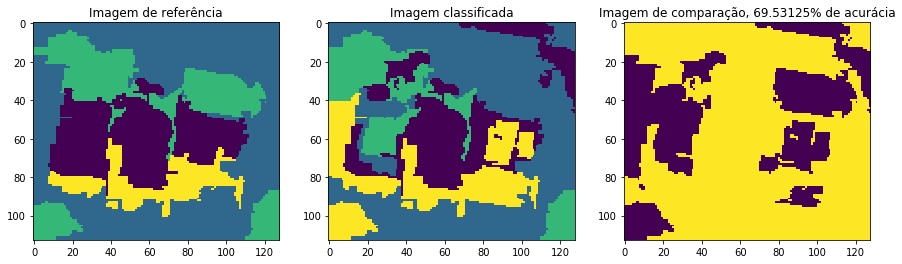

In [14]:
if (dataset_reference.GetProjectionRef() != dataset_classification.GetProjectionRef()):
    print("Sistemas de referência diferentes")
elif (dataset_reference.GetGeoTransform() != dataset_classification.GetGeoTransform()):
    print("Metadados espaciais diferentes")
else:
    # obter metadados
    linhas = dataset_reference.RasterYSize
    colunas = dataset_reference.RasterXSize

    # obter as bandas
    band_reference = dataset_reference.GetRasterBand(1)
    band_classification = dataset_classification.GetRasterBand(1)

    # gerar matrizes de pixels
    numpy_reference = band_reference.ReadAsArray()
    numpy_classification = band_classification.ReadAsArray()

    # gerar matriz de comparação
    numpy_comparison = (numpy_reference == numpy_classification)
    accuracy = 100 * numpy_comparison.sum() / (linhas * colunas)

    # plotar resultados
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.imshow(numpy_reference)
    plt.title('Imagem de referência')

    plt.subplot(132)
    plt.imshow(numpy_classification)
    plt.title('Imagem classificada')

    plt.subplot(133)
    plt.imshow(numpy_comparison)
    plt.title('Imagem de comparação, ' + str(accuracy) + '% de acurácia')

    plt.show()

# salvar imagem de concordância
nome_do_arquivo = os.path.join(f_tif, 'comparacao.tif')
salvar_banda(numpy_comparison, nome_do_arquivo, dataset_reference)

# fechar imagens
dataset_reference = None
dataset_classification = None

In [15]:
os.listdir(f_tif)

['classificacao_area_urbana.tif',
 'comparacao.tif',
 'crop-1-band-5.tfw',
 'crop-1-band-5.tif',
 'crop-1-band-5.tif.aux.xml',
 'crop-1-band-7.tfw',
 'crop-1-band-7.tif',
 'crop-1-band-7.tif.aux.xml',
 'crop-1-ndvi-1.tif',
 'crop-1-ndvi-threshold.tif',
 'crop-2-band-5.tfw',
 'crop-2-band-5.tif',
 'crop-2-band-5.tif.aux.xml',
 'crop-2-band-7.tfw',
 'crop-2-band-7.tif',
 'crop-2-band-7.tif.aux.xml',
 'referencia_area_urbana.tif']